In [5]:
#
# From https://minerl.io/docs/environments/index.html#id9
#
import gym
from gym import spaces
import minerl
import logging
import numpy as np
import collections
import torch
from itertools import chain

In [166]:
device = torch.device("cpu")

In [19]:
minerl.data.download('./experiments',experiment='MineRLNavigateDense-v0')

./experiments\MineRLNavigateDense-v0 exists - skipping re-download!


'./experiments'

In [ ]:
env = gym.make("MineRLNavigateDense-v0") # A MineRLNavigateDense-v0 env

In [ ]:
%run CameraConverter.ipynb
%run DQNAgent.ipynb
cc = CameraConverter()
modified_action_space = spaces.Dict({
    "attack": spaces.Discrete(2),
    "back": spaces.Discrete(2),
    "forward": spaces.Discrete(2),
    "jump": spaces.Discrete(2),
    "left": spaces.Discrete(2),
    "right": spaces.Discrete(2),
    "sneak": spaces.Discrete(2),
    "sprint": spaces.Discrete(2),
    "camera": cc.discrete_space
})

agent_config = {
    "EPS": .99,
    "EPS_DECAY": .995,
    "GAMMA": 1,
    "MEMORY_CAPACITY": 100000,
    "MEMORY_ALPHA": .7,
    "MEMORY_BETA": .4,
    "MEMORY_EPSILON": .001,
    "BATCH_SIZE": 64
}
agent = DQNAgent(env.observation_space, modified_action_space, agent_config)

In [ ]:
# Run a random agent through the environment
def train(env, agent, config):
    
    num_episodes = config["NUM_EPISODES"]
    episodic_rewards = [0] * num_episodes
    episodic_epsilon = [0] * num_episodes
    episodic_moves = [0] * num_episodes
    
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        net_reward = 0
        steps = 0
        pov = obs["pov"].reshape(3,64,64)
        while not done:
            pov_tensor = torch.from_numpy(obs["pov"].reshape(3,64,64)).float().to(device).unsqueeze(0)
            compass = torch.from_numpy(obs['compassAngle']).float().to(device).unsqueeze(0)
            
            action = agent.step(pov_tensor,compass)
    
            env_action = action.copy()
            #env_action['camera'] = [0,0.03*obs['compassAngle']]
            env_action["camera"] = cc.discrete_to_box(action["camera"])
    
            steps = steps + 1
            obs, reward, done, info = env.step(env_action)
    
            next_pov = obs["pov"].reshape(3,64,64)
            if done:
                next_pov_tensor = None
                break;
            else:
                next_pov_tensor = torch.from_numpy(next_pov).float().to(device).unsqueeze(0)
    
            flat_actions = np.hstack(list(action.values()))
            #print(flat_actions)
            camera_flat = np.hstack(list(flat_actions[2].values()))
            flat_actions = np.delete(flat_actions, 2)
            flat_actions = np.insert(flat_actions, 2, camera_flat).astype(int)
    
            action_tensor = torch.from_numpy(flat_actions).to(device).float().unsqueeze(0)
            reward_tensor = torch.tensor([reward], device=device)
            
            
            next_compass = torch.from_numpy(obs['compassAngle']).float().to(device).unsqueeze(0)
            
            
            agent.memory.store_transition(Transition(next_pov_tensor,compass, action_tensor, next_pov_tensor,next_compass, reward_tensor))
            if steps % config["EVAL_INTERVAL"] == 0:
                    agent.evaluate(next_pov_tensor,compass, action, next_pov_tensor,next_compass, reward)
            pov = next_pov     
            episodic_rewards[episode] += reward
            episodic_moves[episode] += 1
    
        if episode % config["SYNC_INTERVAL"] == 0:
            agent.agent_sync_networks()
        episodic_epsilon[episode] = agent.epsilon
        agent.decay_epsilon()
        print(episode)
        print(episodic_rewards[episode])
    return episodic_rewards, episodic_epsilon, episodic_moves        
     
    # Do something

In [177]:
train_config = {
    "EVAL_INTERVAL": 10,
    "SYNC_INTERVAL": 5,
    "NUM_EPISODES": 20
}
rew, ep, moves = train(env, agent, train_config)

0
1
2
3
4


In [179]:
env.close()

Failed to delete the temporary minecraft directory.


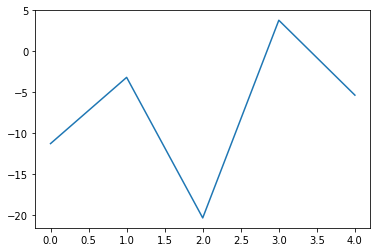

In [178]:
import matplotlib.pyplot as plt
plt.plot(rew)
plt.show()

In [ ]:
# Sample some data from the dataset!
data = minerl.data.make("MineRLNavigateDense-v0")

In [ ]:
# Iterate through a single epoch using sequences of at most 32 steps
for current_state, action, reward, next_state, done in data.batch_iter(num_epochs=1, batch_size=1, seq_len=32):
    print(current_state)
    break